# Riesgo de Diabetes
# A )

In [1]:
import sys
import os
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(ROOT_DIR)
sys.path.append('../src/')

import pandas as pd
import numpy as np

from split import train_val_split
from models import LinearDiscriminantAnalysis, LogisticRegressionMulticlass, RandomForest
from metrics import imprimir_metricas, accuracy, recall, precision, f1_score
from metrics import plot_confusion_matrix, confusion_matrix, calcular_roc_multiclase, calcular_pr_multiclase, plot_roc_multiclase, plot_pr_multiclase, calcular_auc
from sampling import undersampling

In [2]:
archivo_csv = '../data/raw/diabetes_dev.csv'
data = pd.read_csv(archivo_csv)
train_data, val_data = train_val_split(data, train_size=0.8)

X_train = train_data.drop(columns=['Diabetes']).to_numpy()
y_train = train_data['Diabetes'].to_numpy()
X_val = val_data.drop(columns=['Diabetes']).to_numpy()
y_val = val_data['Diabetes'].to_numpy()

#para undersampling
X_resampled, y_resampled = undersampling(X_train, y_train)
#para plotear las matrices de confusión
labels = [0, 1, 2]

### 1) Análisis discriminante lineal (Linear Discriminant Analysis, LDA)

Clase     Accuracy  Precision Recall    F1 Score  
--------------------------------------------------
0.0       0.7043    0.8999    0.7648    0.8268    
1.0       0.7043    0.0289    0.1464    0.0482    
2.0       0.7043    0.2904    0.4042    0.3380    


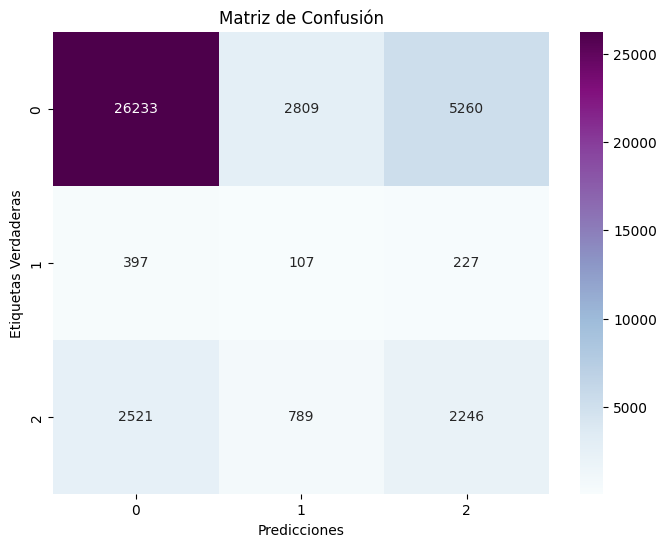

In [46]:
modelo_lda = LinearDiscriminantAnalysis()
modelo_lda.fit(X_train, y_train)
y_pred = modelo_lda.predict(X_val)

imprimir_metricas(y_val, y_pred)
matrix = confusion_matrix(y_val, y_pred, labels)
plot_confusion_matrix(matrix, labels)

Este modelo predice la mayoria de las clases como clase 0. Vemos de entrenar el modelo con datos hechos con undersampling para tener proporciones no tan diferentes entre las clases del conjunto de entrenamiento.

Clase     Accuracy  Precision Recall    F1 Score  
--------------------------------------------------
0.0       0.7038    0.9031    0.7643    0.8279    
1.0       0.7038    0.0286    0.1573    0.0484    
2.0       0.7038    0.2964    0.4023    0.3413    


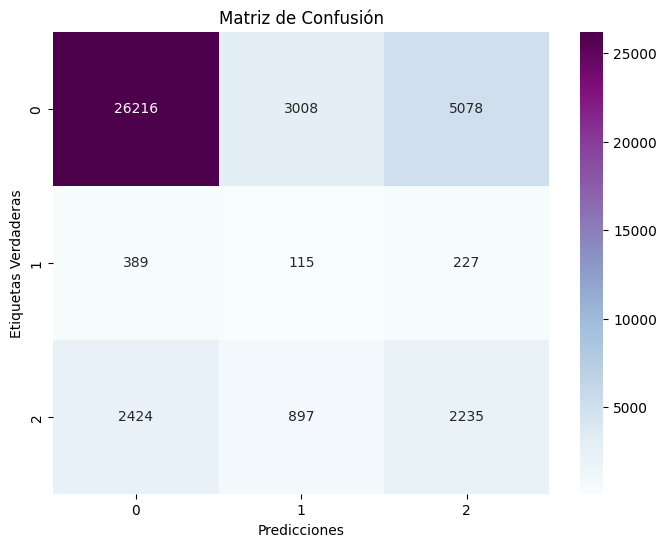

In [3]:
modelo_lda_u = LinearDiscriminantAnalysis()
modelo_lda_u.fit(X_resampled, y_resampled)
y_pred_u = modelo_lda_u.predict(X_val)

imprimir_metricas(y_val, y_pred_u)
matrix = confusion_matrix(y_val, y_pred_u, labels)
plot_confusion_matrix(matrix, labels)

Si hacemos undersampling, mejora pero solo un poco, ya que sigue prediciendo mal en la mayoría de los casos clasificados como Pre-Diabetes y Diabetes. Todas las clases son predecidas mayoritariamente como clase 0, como pacientes sin diabetes (la muestra dominante). 

### 2) Regresión logística multi-clase

Clase     Accuracy  Precision Recall    F1 Score  
--------------------------------------------------
0.0       0.8451    0.8451    1.0000    0.9161    
1.0       0.8451    0.0000    0.0000    0.0000    
2.0       0.8451    0.0000    0.0000    0.0000    


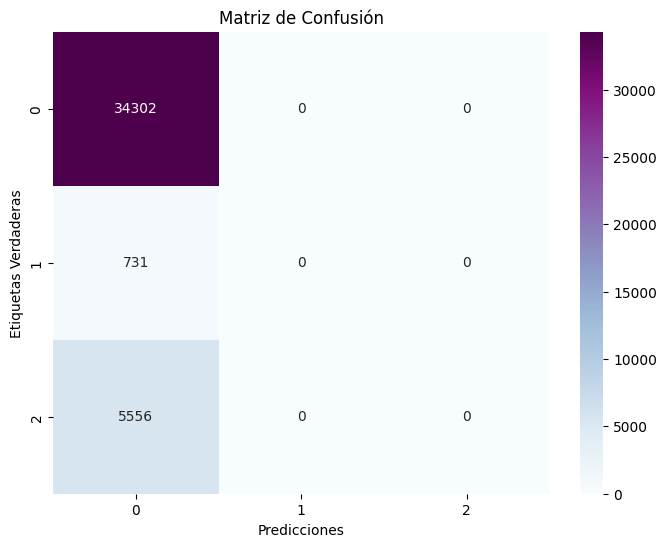

In [66]:
modelo_lrm = LogisticRegressionMulticlass(learning_rate=0.1, num_iterations=700, lambda_reg=0.1)
modelo_lrm.fit(X_train, y_train)
y_pred = modelo_lrm.predict(X_val)

imprimir_metricas(y_val, y_pred)
matrix = confusion_matrix(y_val, y_pred, labels)
plot_confusion_matrix(matrix, labels)

Este modelo parecería ni siquiera predecir la clase 1 y 2 en ninguno de los casos del set de validación. Se volverá a implementar este modelo pero entrenándolo con un conjunto de datos hecho con undersamplin, para ver si cambia alguna métrica y si logra predecir a las clases 1 y 2.

Clase     Accuracy  Precision Recall    F1 Score  
--------------------------------------------------
0.0       0.2775    0.9901    0.1727    0.2941    
1.0       0.2775    0.0131    0.0971    0.0231    
2.0       0.2775    0.1806    0.9487    0.3035    


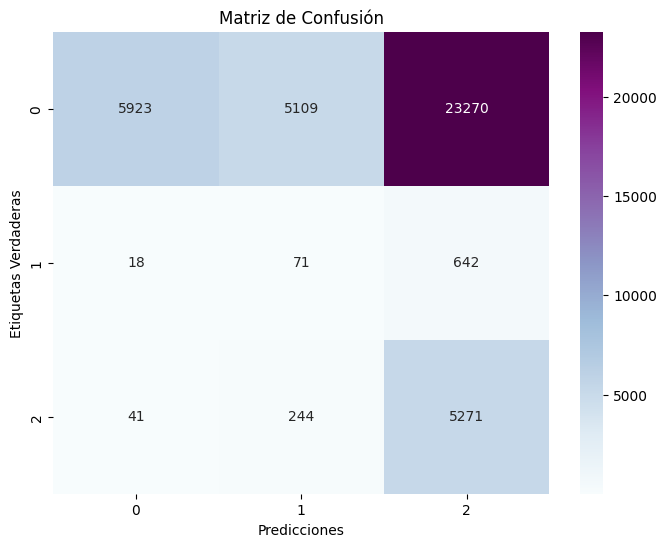

In [17]:
modelo_lrm_u = LogisticRegressionMulticlass(learning_rate=0.1, num_iterations=1000, lambda_reg=0.1)
modelo_lrm_u.fit(X_resampled, y_resampled)
y_pred_u = modelo_lrm_u.predict(X_val)

imprimir_metricas(y_val, y_pred_u)
matrix = confusion_matrix(y_val, y_pred_u, labels)
plot_confusion_matrix(matrix, labels)

En este caso empeoran las métricas de predicción de la clase 0 (la dominante) porque baja la acccuracy y el recall y por ende la f-score, pero de las predicciones 0, la gran mayoría son correctas. La clase 1 sigue sin ser clasificada correctamtente, pero al menos ahora hay predicciones de esta. En el caso de la clase 2, el modelo está generalizando mal y prediciendo a tuna gran mayoría de las muestras como si pertenecieran a esta clase; entonces hay malas predicciones de clase 2 en total ya que estás aumentan, pero de las muestras etiquetadas como clase 2 (pacientes con diabetes) hay una mayor proporción de datos bien etiquetados. Entonces este upgrade solo sirve para disminuir la cantidad de falsos negativos de diabetes, pero aumenta la cantidad de falsos positivos. De igual manera este modelo sigue teniendo muchas fallas, ya que ahora es sesgado por la clase 2. Pero al menos logra predecir la clase 1 y 2, que antes no era posible. 

### 3) Bosque aleatorio (Random Forest) utilizando la entropía como criterio de división. Se recomienda experimentar con diferentes configuraciones de hi- perparámetros (número de árboles, profundidad máxima, etc.) y seleccionar la mejor combinación en función de los resultados obtenidos. 

Probando con una cantidad pequeña de árboles:

Clase     Accuracy  Precision Recall    F1 Score  
--------------------------------------------------
0.0       0.8479    0.8626    0.9781    0.9167    
1.0       0.8479    0.0000    0.0000    0.0000    
2.0       0.8479    0.5115    0.1559    0.2389    


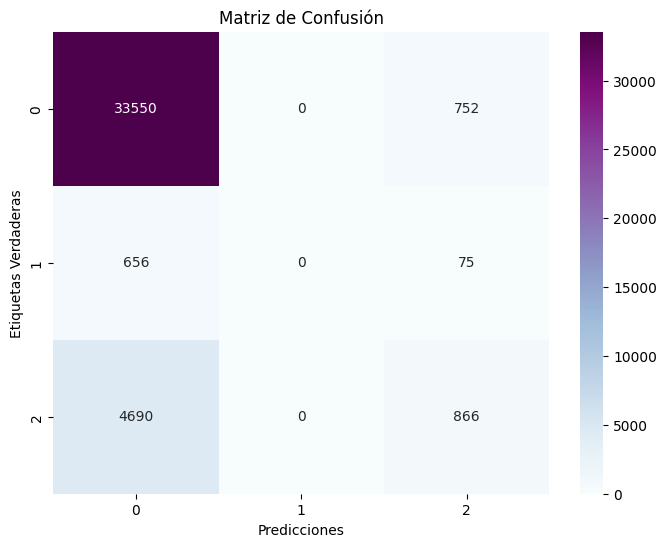

In [50]:
model_rf_10 = RandomForest(n_trees=10, max_depth=5, min_samples_leaf=2, min_information_gain=0.01)
model_rf_10.train(X_train, y_train)
y_pred = model_rf_10.predict(X_val)

imprimir_metricas(y_val, y_pred)
matrix = confusion_matrix(y_val, y_pred, labels)
plot_confusion_matrix(matrix, labels)

Este modelo tiene métricas muy buenas para la clase 0 ya que el modelo clasifica a la mayoría de las muestras con target 0 y predecir esta clase tiene un muy buenos resultados, para la clase misma. Luego para la clase 2 tiene una accuracy alta pero las demas métricas son malas. Y como en los casos anteriores, no parece estar prediciendo clase 1 para ninguno de los casos. 

Si se aumenta la cantidad de árboles del random forest no parecerían haber mejoras en el rendimiento:

Clase     Accuracy  Precision Recall    F1 Score  
--------------------------------------------------
0.0       0.8479    0.8626    0.9781    0.9167    
1.0       0.8479    0.0000    0.0000    0.0000    
2.0       0.8479    0.5115    0.1559    0.2389    


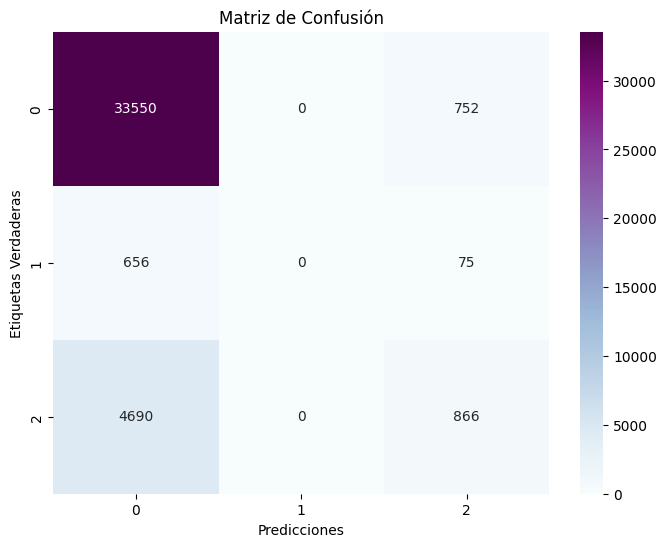

In [51]:
# 100 árboles
model_rf_100 = RandomForest(n_trees=100, max_depth=4, min_samples_leaf=2, min_information_gain=0.01)
model_rf_100.train(X_train, y_train)

y_pred_100 = model_rf_100.predict(X_val)
imprimir_metricas(y_val, y_pred_100)
matrix = confusion_matrix(y_val, y_pred_100, labels)
plot_confusion_matrix(matrix, labels)

Si al conjunto de entrenamiendo se le raliza un sapmpleo con undersampling tal vez la diferencia abismal entre las muestras etiquetadas como 0 (la muestra dominante) y la clase 1 (la más débil) no es tan grande, entonces no se sesga al modelo. A continuación se intenta entrenar el modelo con undersampling. 

Clase     Accuracy  Precision Recall    F1 Score  
--------------------------------------------------
0.0       0.6211    0.9498    0.6301    0.7576    
1.0       0.6211    0.0281    0.2695    0.0508    
2.0       0.6211    0.3142    0.6114    0.4151    


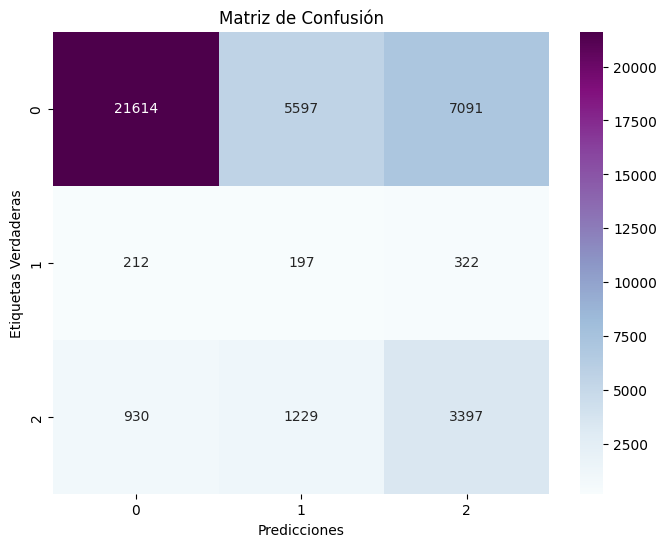

In [52]:
model_rf_75_u = RandomForest(n_trees=75, max_depth=4, min_samples_leaf=2, min_information_gain=0.01)
model_rf_75_u.train(X_resampled, y_resampled)

y_pred_75_u = model_rf_75_u.predict(X_val)
imprimir_metricas(y_val, y_pred_75_u)
matrix = confusion_matrix(y_val, y_pred_75_u, labels)
plot_confusion_matrix(matrix, labels)

Realizando undersampling las métricas para las clases no dominantes parecerían mejorar, aún si el funcionamiento del modelo no es el óptimo. Las mejores métricas las tiene la clase 0, seguidas por las de la clase 2, y por último la clase 1, que al menos se está prediciendo algo para esta clase. Se restaca el recall mayor a 0.5 para la clase 2, ya que para los pacientes con diabetes hay una menor cantidad de falsos negativos, es decir que no se le está diciendo a un diabético que no tiene nada.  

A continuación se realizaron diferentes modelos utilizando undersampling para el entrenamiento, pero después de variar diferentes parámetros como la cantidad de árboles, la profundidad y el mínimo de hojas por nodo, se llegó a la conclusión que el mejor modelo era el siguiente:

Clase     Accuracy  Precision Recall    F1 Score  
--------------------------------------------------
0.0       0.6231    0.9525    0.6273    0.7564    
1.0       0.6231    0.0280    0.2572    0.0505    
2.0       0.6231    0.3180    0.6456    0.4261    


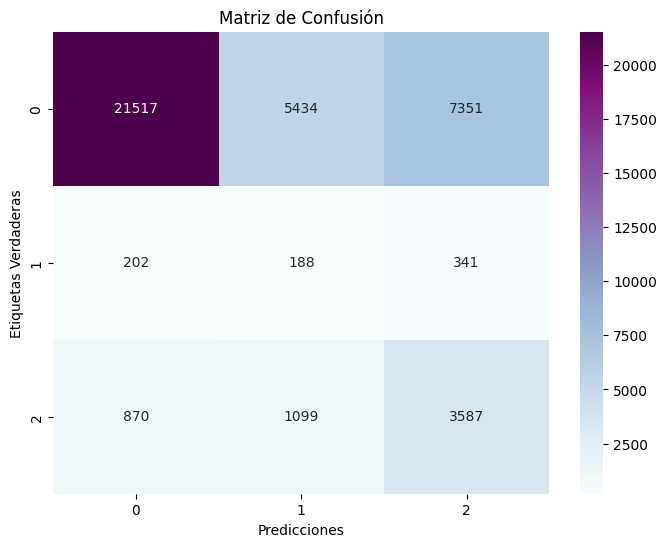

In [19]:
X_resampled, y_resampled = undersampling(X_train, y_train)
model_rf = RandomForest(n_trees=150, max_depth=6, min_samples_leaf=2, min_information_gain=0.01)
model_rf.train(X_resampled, y_resampled)

y_pred = model_rf.predict(X_val)
imprimir_metricas(y_val, y_pred)
matrix = confusion_matrix(y_val, y_pred, labels)
plot_confusion_matrix(matrix, labels)

Las métricas en general no son magníficas, pero de todas las combinaciones de intentos fueron las mejores que se consiguiron. A la hora de predecir clase 0, el modelo acierta en la gran mayoría de los casos. Para predecir la clase 1 no hay avances muy notorios, pero al menos no los categoriza como clase 0 en la mayoría de los casos, sino que suele predecirlos como clase 2 o clase 1, y dado que estás dos funcionan como positivos, ya que no son pacientes libres de diabetes (no del todo), se lo considera como una mini-victoria, al menos el modelo los esta difeenciando de pacientes "sanos" o no portadores de uan posible diabetes. Para los casos etiquetados como diabetes/clase 2 el modelo predice en la mayoría de los casos correctamente, y cuando no lo hace predice la clase 1, pre-diabetes, que debería tener features más parecidas que los de clase 0. 

# B) 
Evaluar las distintas métricas de performance (matriz de confusión, accuracy, precision, recall, f-score, curva PR, curva ROC, AUC-ROC y AUC-PR) de cada modelo sobre el conjunto de datos diabetes_test.csv, y presentar los resultados de manera compacta para facilitar la comparación entre los modelos. Definir cuál de ellos enviará a producción y justificar por qué.

In [9]:
archivo_csv = '../data/raw/diabetes_test.csv'
test = pd.read_csv(archivo_csv)
X_test = test.drop(columns=['Diabetes']).to_numpy()
y_test = test['Diabetes']

In [21]:
models = [modelo_lda_u, modelo_lrm_u, model_rf]
names = ['Análisis discriminante lineal', 'Regresión logística multi-clase', 'Bosque aleatorio']
for i in range(3):
    print(""" 
          """)
    print(names[i])
    y_pred = models[i].predict(X_test)
    imprimir_metricas(y_test, y_pred)

 
          
Análisis discriminante lineal
Clase     Accuracy  Precision Recall    F1 Score  
--------------------------------------------------
0.0       0.6991    0.9013    0.7600    0.8247    
1.0       0.6991    0.0336    0.1857    0.0568    
2.0       0.6991    0.2940    0.3980    0.3382    
 
          
Regresión logística multi-clase
Clase     Accuracy  Precision Recall    F1 Score  
--------------------------------------------------
0.0       0.2804    0.9855    0.1753    0.2977    
1.0       0.2804    0.0132    0.0972    0.0232    
2.0       0.2804    0.1830    0.9395    0.3063    
 
          
Bosque aleatorio
Clase     Accuracy  Precision Recall    F1 Score  
--------------------------------------------------
0.0       0.6192    0.9497    0.6259    0.7546    
1.0       0.6192    0.0250    0.2225    0.0449    
2.0       0.6192    0.3110    0.6303    0.4165    


#### Curvas del primer modelo: Análisis discriminante lineal

/Users/titigrune/Desktop/Cuatrimestre actual/ML/Grünewald_Martina_TP3/Problema 2/src/models.py:73: RuntimeWarning: invalid value encountered in divide
  probabilidades_clase /= np.sum(probabilidades_clase)


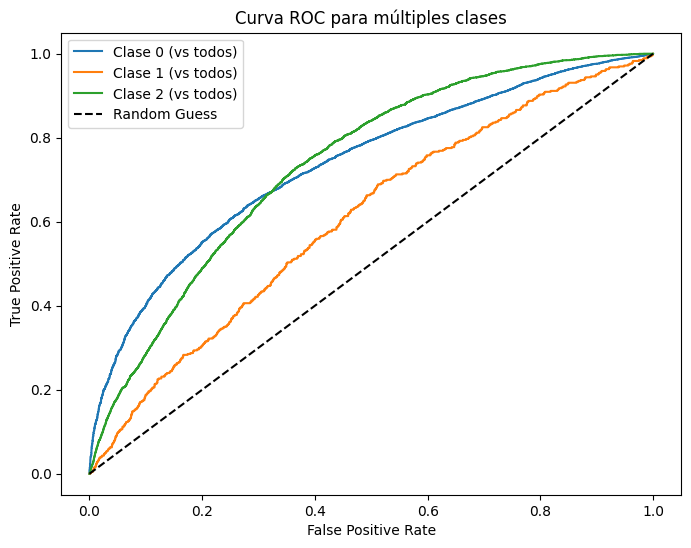

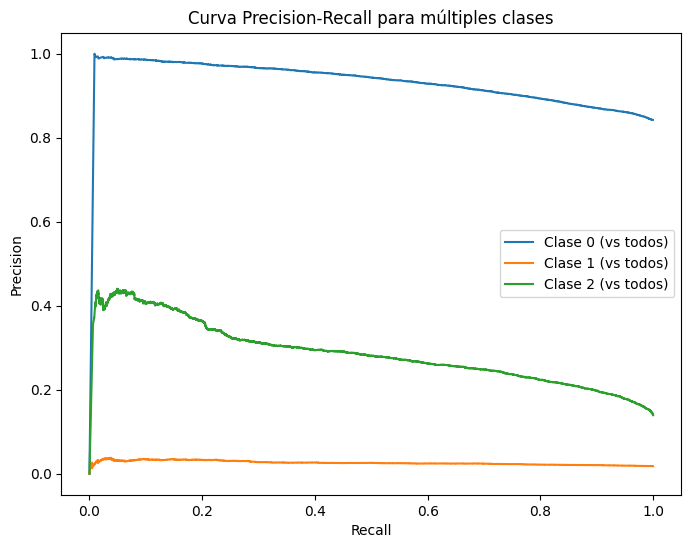

AUC-ROC para la clase 0: 0.7363048978864724
AUC-PR para la clase 0: 0.9306485797435571
AUC-ROC para la clase 1: 0.6063928023682217
AUC-PR para la clase 1: 0.025994186480929365
AUC-ROC para la clase 2: 0.7372134145974091
AUC-PR para la clase 2: 0.28673251558628504


/var/folders/41/r2_v33t512j_hc2xpxfmbjpr0000gn/T/ipykernel_18984/1200146354.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, x)


In [8]:
# Obtener las probabilidades
y_proba = modelo_lda_u.predict_proba(X_test)
roc_points = calcular_roc_multiclase(y_test, y_proba, num_classes=3)
plot_roc_multiclase(roc_points, num_classes=3)
pr_points = calcular_pr_multiclase(y_test, y_proba, num_classes=3)
plot_pr_multiclase(pr_points, num_classes=3)
for clase in range(3):
    fpr, tpr = roc_points[clase]
    auc_roc = calcular_auc(fpr, tpr)
    print(f'AUC-ROC para la clase {clase}: {auc_roc}')
    precision, recall = pr_points[clase]
    auc_pr = calcular_auc(recall, precision)
    print(f'AUC-PR para la clase {clase}: {auc_pr}')


#### Curvas del segundo modelo: Regresión logística multi-clase

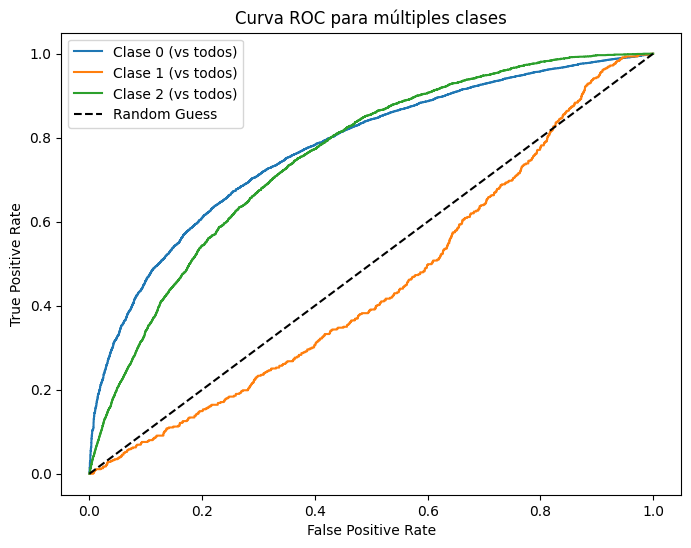

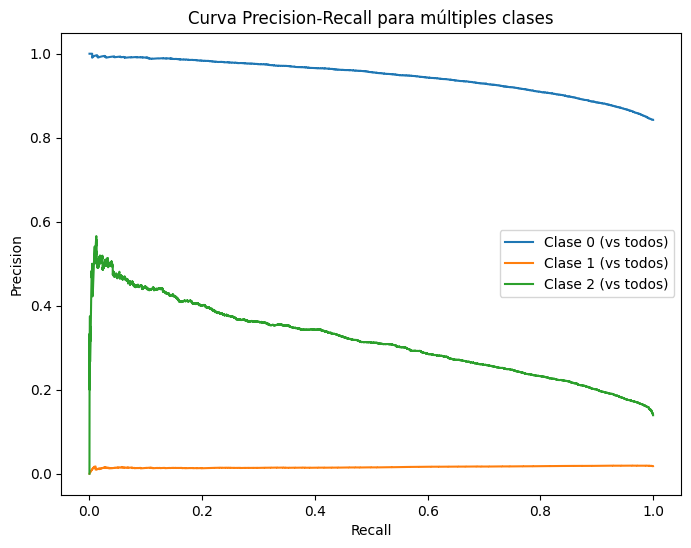

AUC-ROC para la clase 0: 0.7754293852588439
AUC-PR para la clase 0: 0.946000518946458
AUC-ROC para la clase 1: 0.4517355584048759
AUC-PR para la clase 1: 0.01574515466329562
AUC-ROC para la clase 2: 0.7556583985766716
AUC-PR para la clase 2: 0.31621515742830153


/var/folders/41/r2_v33t512j_hc2xpxfmbjpr0000gn/T/ipykernel_18984/1200146354.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, x)


In [18]:
# Obtener las probabilidades
y_proba = modelo_lrm_u.predict_proba(X_test)
roc_points = calcular_roc_multiclase(y_test, y_proba, num_classes=3)
plot_roc_multiclase(roc_points, num_classes=3)
pr_points = calcular_pr_multiclase(y_test, y_proba, num_classes=3)
plot_pr_multiclase(pr_points, num_classes=3)
for clase in range(3):
    fpr, tpr = roc_points[clase]
    auc_roc = calcular_auc(fpr, tpr)
    print(f'AUC-ROC para la clase {clase}: {auc_roc}')
    precision, recall = pr_points[clase]
    auc_pr = calcular_auc(recall, precision)
    print(f'AUC-PR para la clase {clase}: {auc_pr}')

#### Curvas del segundo modelo: Bosque Aleatorio

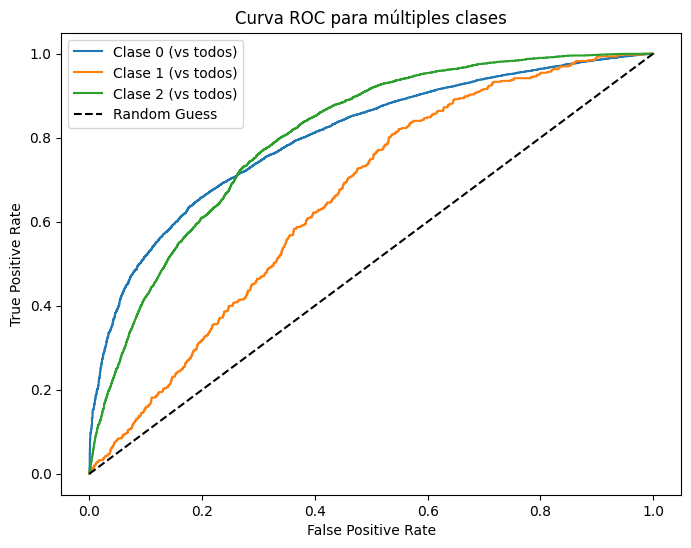

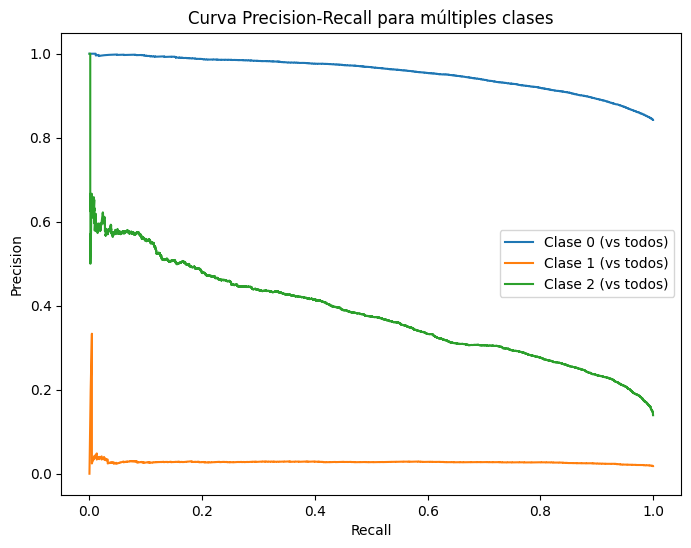

AUC-ROC para la clase 0: 0.80142866238922
AUC-PR para la clase 0: 0.9540191980101891
AUC-ROC para la clase 1: 0.6530907296538943
AUC-PR para la clase 1: 0.02798687582700108
AUC-ROC para la clase 2: 0.8027992156741307
AUC-PR para la clase 2: 0.37943485333403937


/var/folders/41/r2_v33t512j_hc2xpxfmbjpr0000gn/T/ipykernel_18984/1200146354.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(y, x)


In [20]:
y_proba = model_rf.predict_proba(X_test)
roc_points = calcular_roc_multiclase(y_test, y_proba, num_classes=3)
plot_roc_multiclase(roc_points, num_classes=3)
pr_points = calcular_pr_multiclase(y_test, y_proba, num_classes=3)
plot_pr_multiclase(pr_points, num_classes=3)
for clase in range(3):
    fpr, tpr = roc_points[clase]
    auc_roc = calcular_auc(fpr, tpr)
    print(f'AUC-ROC para la clase {clase}: {auc_roc}')
    precision, recall = pr_points[clase]
    auc_pr = calcular_auc(recall, precision)
    print(f'AUC-PR para la clase {clase}: {auc_pr}')

La verdad es que son modelos que no funcionan de la manera más óptima, pero considerando las métricas calculadas y el caso en cuestión a clasificar, que es un diagnóstico de una enfermedad que puede dañar la salud hasta el punto de la muerte, se va escoger el método que mejores métricas tenga para las clases 1 y 2. Observando eso y los gráfios de las curvas se enviaría a producción el modelo hecho con Bosque Aleatorios, con 150 árboles y 6 niveles de profundidad por árbol. Este modelo tiene la mayor AUC y mejores métricas en promedio para las clases 1 y 2, las métricas de pacientes los cuales deberían ser tratados u observados de cerca para no empeorar su salud. 